<a href="https://colab.research.google.com/github/ferDMS/green-pandas-datathon/blob/main/GreenPandas_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data sourcing and preprocessing

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hashlib
from datetime import datetime


In [56]:
# Load the 'Flights' and 'Sales' tables into DataFrame variables
flights_data = pd.read_csv('Filghts TEC_Valid.csv')

In [57]:
sales_data = pd.read_csv('Sales TEC_Valid.csv')

## Preprocessing of Flights Data


### Asignar un id único según la ruta de vuelo

In [58]:
# Convert date columns to datetime
flights_data['STD'] = pd.to_datetime(flights_data['STD'])
flights_data['STA'] = pd.to_datetime(flights_data['STA'])

# Función para crear un "hash" de la ruta
def get_route_id(row):
    # Check if either STD or STA is NaT
    if pd.isnull(row['STD']) or pd.isnull(row['STA']):
        return None

    # Extract hour and minute components from the datetime objects
    std_hour_minute = row['STD'].strftime('%H:%M')
    sta_hour_minute = row['STA'].strftime('%H:%M')

    # Concatenate the departure station, arrival station, and hour-minute components
    return f"{row['DepartureStation']}_{row['ArrivalStation']}_{std_hour_minute}_{sta_hour_minute}"

# Aplicar la función hash para crear la columna 'Route_Hash'
flights_data['Route_Hash'] = flights_data.apply(get_route_id, axis=1)

# Apply the factorize method to create the 'Route_ID' column
flights_data['Route_ID'] = flights_data['Route_Hash'].factorize()[0]

In [59]:
# Verificar el resultado mostrando entradas únicas por 'Route_ID'
unique_routes = flights_data[['Route_Hash', 'Route_ID']].drop_duplicates()
unique_routes

,Route_Hash,Route_ID
0,AL_AT_16:20_18:35,0
1,BN_AW_20:00_21:35,1
2,AT_BD_15:10_16:50,2
3,AK_AD_18:55_20:30,3
4,AO_BD_13:35_14:30,4
...,...,...
245456,AF_AW_12:05_14:45,9878
245499,AW_BA_21:40_23:10,9879
245502,BA_AY_13:25_14:05,9880
245549,AW_BC_18:00_19:30,9881


### Más procesamiento

- imputar datos de passengers que no se encuentren según el promedio de passengers para esa ruta,
- limitar datos a 2023,
- quitar datos poco relevantes

In [60]:
# Filter data for the year 2023
flights_data = flights_data[(flights_data['STD'].dt.year == 2023) & (flights_data['STD'].dt.month == 3)]

# Replacing the number of passengers with the capacity maximum of the airplane if it exceeds the capacity
flights_data['Passengers'] = flights_data[['Passengers', 'Capacity']].min(axis=1)

# Fill missing values in 'Passengers' column with median for each route
flights_data['Passengers'] = flights_data.groupby(['Route_ID'])['Passengers'].transform(lambda x: x.fillna(x.median()))

# Fill missing values in 'Bookings' column with mean for each route
flights_data['Bookings'] = flights_data.groupby(['Route_ID'])['Bookings'].transform(lambda x: x.fillna(x.mean()))

# Calculate the flight duration between STD and STA, in minutes
flights_data['Duration'] = (flights_data['STA'] - flights_data['STD']).dt.total_seconds() / 60  # in minutes

# Drop irrelevant columns and datetime columns because we already created specific unique routes and duration
flights_data.drop(columns=['Aeronave', 'Route_Hash'], inplace=True)

# Display the modified DataFrame
flights_data.head()

,Flight_ID,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings,Route_ID,Duration
11,0003fa35aaf9da072ecba3035d426459,BQ,AW,Ciudad Principal,MX Amigos y Familia,2023-03-27 19:55:00,2023-03-27 22:00:00,240,235.0,183.0,11,125.0
96,0018331757f2e15c1eac9f72ad96933f,AB,AW,Ciudad Principal,Playa,2023-03-02 16:30:00,2023-03-02 18:25:00,240,203.0,132.0,95,115.0
123,00202ce9f89a05aecf3ff29ba969582b,AW,AT,Ciudad Principal,Ciudad Principal,2023-03-18 06:00:00,2023-03-18 07:35:00,186,186.0,138.0,122,95.0
135,002300170101dd7bef9f08a07f8c7194,AT,BH,Playa,Ciudad Principal,2023-03-29 13:55:00,2023-03-29 15:15:00,240,225.0,143.0,132,80.0
187,002f75f6cc12b97d7f38bf7379ad5e67,BM,AT,Ciudad Principal,Ciudad Fronteriza,2023-03-22 00:55:00,2023-03-22 05:20:00,240,167.0,111.0,181,265.0


## Preprocessing of Sales Data

In [61]:
# Usar únicamente productos relevantes (que van en vuelo)
categories_to_keep = ['Botanas', 'Licores', 'Refrescos', 'Galletas', 'Sopas',
                      'Perecederos', 'Bebidas Calientes', 'Lacteos', 'Alimentos Charter']

# Filtrar el DataFrame para mantener solo las categorías deseadas
sales_data = sales_data[sales_data['ProductType'].isin(categories_to_keep)]

## Después de filtrado, unir tablas para obtener productos a analizar

In [62]:
# Join the tables on the common column 'Flight_ID'
merged_data = pd.merge(flights_data, sales_data, on='Flight_ID', how='left')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66228 entries, 0 to 66227
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Flight_ID         66228 non-null  object        
 1   DepartureStation  66228 non-null  object        
 2   ArrivalStation    66228 non-null  object        
 3   Destination_Type  66228 non-null  object        
 4   Origin_Type       66228 non-null  object        
 5   STD               66228 non-null  datetime64[ns]
 6   STA               66228 non-null  datetime64[ns]
 7   Capacity          66228 non-null  int64         
 8   Passengers        66228 non-null  float64       
 9   Bookings          66228 non-null  float64       
 10  Route_ID          66228 non-null  int64         
 11  Duration          66228 non-null  float64       
 12  ProductType       65015 non-null  object        
 13  ProductName       65015 non-null  object        
 14  Quantity          6501

# Data visualization

## Total sales from random flight routes

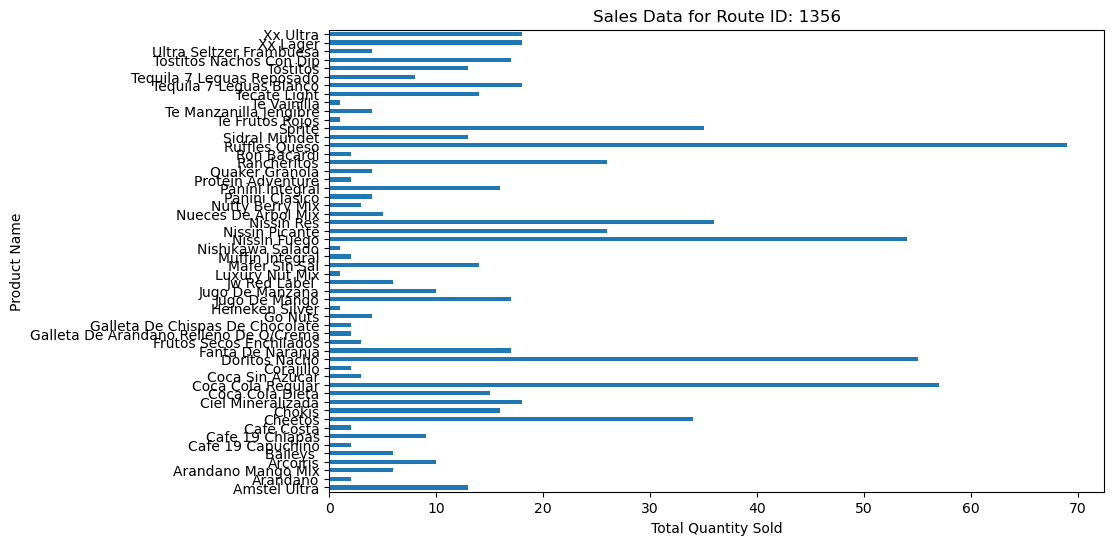

In [63]:
# Select a random route ID
random_route_id = np.random.choice(merged_data['Route_ID'].unique())

# Filter the DataFrame for the selected Route ID
random_route_data = merged_data[merged_data['Route_ID'] == random_route_id]

# Create a simple horizontal visualization of the grouped data
plt.figure(figsize=(10, 6))
random_route_data.groupby('ProductName')['Quantity'].sum().plot(kind='barh')
plt.title(f'Sales Data for Route ID: {random_route_id}')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.show()

## In how many flights Y are X quantity of products sold?

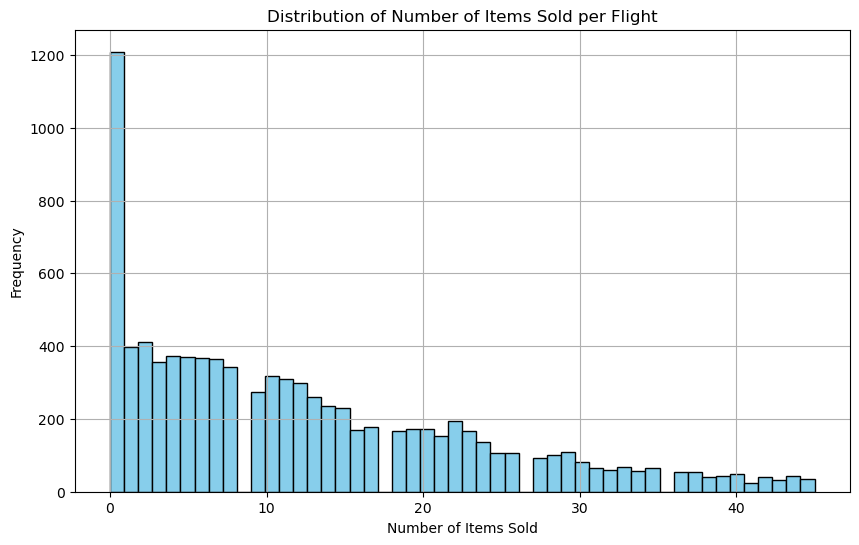

In [64]:
# Group the data by Flight ID and calculate the total number of items sold per flight
items_sold_per_flight = merged_data.groupby('Flight_ID')['Quantity'].sum()

# Define the range for the x-axis (remove outliers)
x_range = (0, items_sold_per_flight.quantile(0.95))

# Plot the distribution of number of items sold per flight
plt.figure(figsize=(10, 6))
plt.hist(items_sold_per_flight, bins=50, range=x_range, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Items Sold per Flight')
plt.xlabel('Number of Items Sold')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## How much of each type of product is sold (sales frequency)

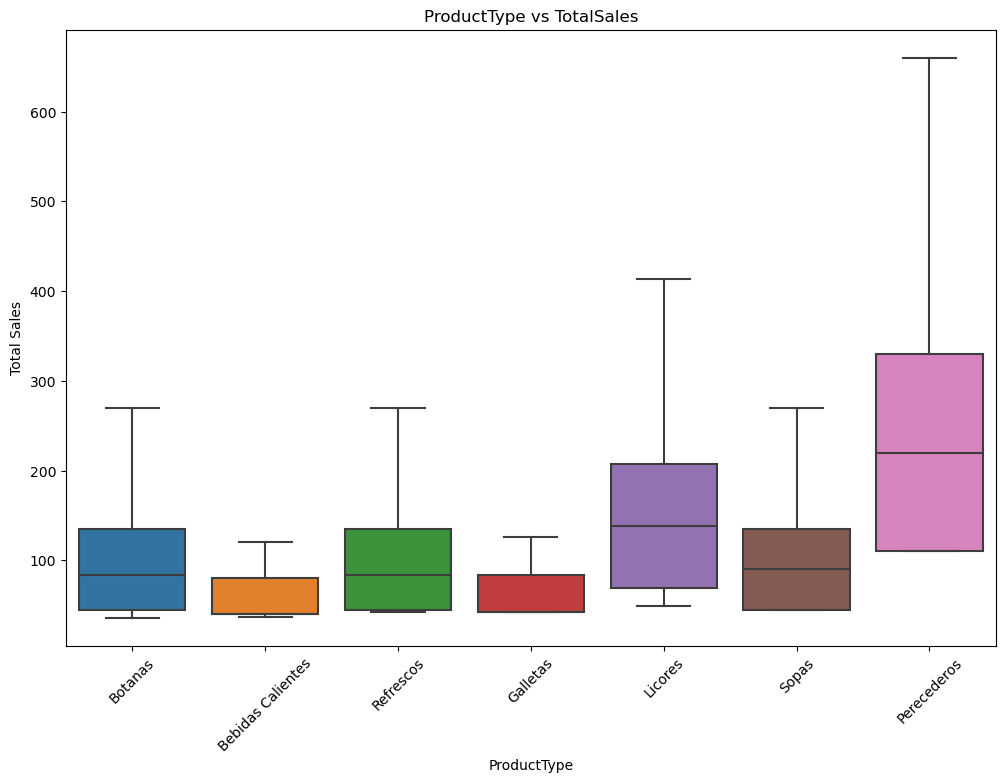

In [65]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='ProductType', y='TotalSales', data=merged_data, showfliers=False)  # Showing outliers
plt.title('ProductType vs TotalSales')
plt.xlabel('ProductType')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

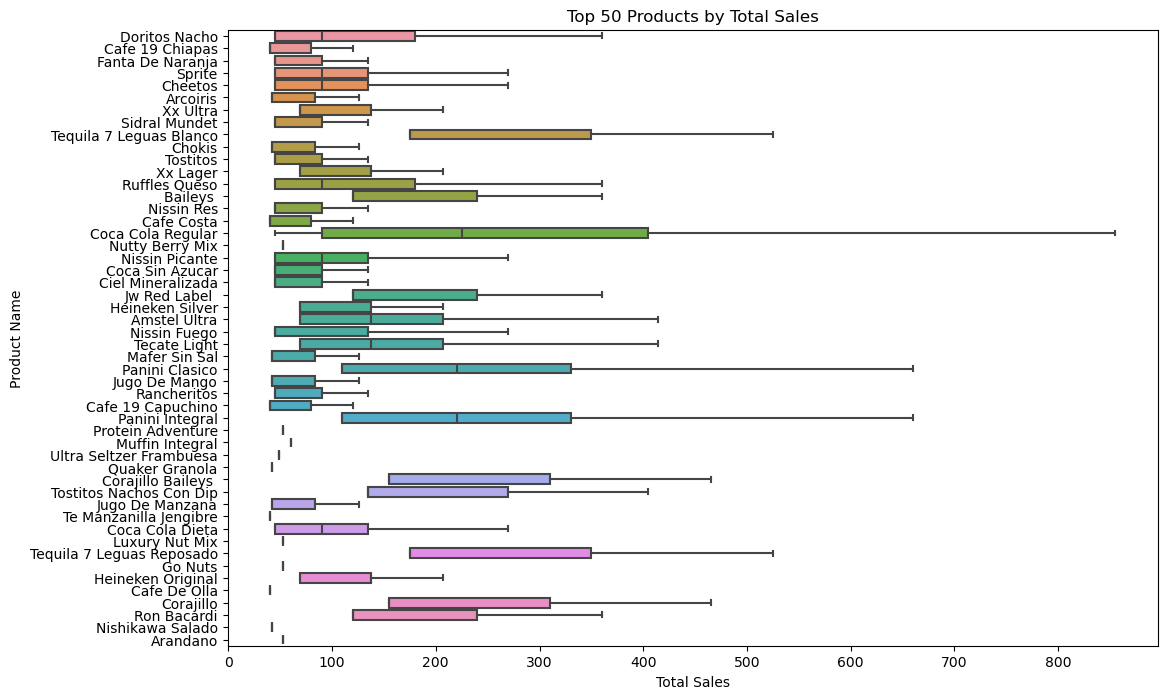

In [66]:
# Calculate total sales for each product
product_sales = merged_data.groupby('ProductName')['TotalSales'].sum().reset_index()

# Select the top 10 products
top_10_products = product_sales.nlargest(50, 'TotalSales')['ProductName']

# Filter the original data for the top 10 products
merged_data_top_10 = merged_data[merged_data['ProductName'].isin(top_10_products)]

# Relationship between ProductName and TotalSales for top 10 products (horizontal)
plt.figure(figsize=(12, 8))
sns.boxplot(x='TotalSales', y='ProductName', data=merged_data_top_10, showfliers=False)  # No outliers
plt.title('Top 50 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.show()


# Model training

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss
from sklearn.preprocessing import OneHotEncoder

In [68]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66228 entries, 0 to 66227
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Flight_ID         66228 non-null  object        
 1   DepartureStation  66228 non-null  object        
 2   ArrivalStation    66228 non-null  object        
 3   Destination_Type  66228 non-null  object        
 4   Origin_Type       66228 non-null  object        
 5   STD               66228 non-null  datetime64[ns]
 6   STA               66228 non-null  datetime64[ns]
 7   Capacity          66228 non-null  int64         
 8   Passengers        66228 non-null  float64       
 9   Bookings          66228 non-null  float64       
 10  Route_ID          66228 non-null  int64         
 11  Duration          66228 non-null  float64       
 12  ProductType       65015 non-null  object        
 13  ProductName       65015 non-null  object        
 14  Quantity          6501

In [69]:
# Columns to drop
cols_to_drop = ['ProductType', 'Flight_ID', 'STD', 'STA', 'DepartureStation', 'ArrivalStation', 'ProductName']

# Drop columns not going to be used
merged_data_encoded = merged_data.drop(columns=cols_to_drop)

# One-hot encode categorical variables
cat_cols = ['Origin_Type', 'Destination_Type', 'Route_ID']
# cat_cols = ['Origin_Type', 'Destination_Type', 'ProductName']
merged_data_encoded = pd.get_dummies(merged_data_encoded, columns=cat_cols)

# Display the first few rows of the encoded dataset
merged_data_encoded.head()


,Capacity,Passengers,Bookings,Duration,Quantity,TotalSales,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,Origin_Type_MX Amigos y Familia,...,Route_ID_9493,Route_ID_9588,Route_ID_9642,Route_ID_9678,Route_ID_9761,Route_ID_9786,Route_ID_9827,Route_ID_9838,Route_ID_9872,Route_ID_9882
0,240,235.0,183.0,125.0,1.0,45.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,240,235.0,183.0,125.0,1.0,40.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,240,235.0,183.0,125.0,1.0,45.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,240,235.0,183.0,125.0,2.0,90.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,240,235.0,183.0,125.0,1.0,45.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [70]:
# Split the data into features (X) and target variable (y)
X = merged_data_encoded.drop(columns=['Passengers'])
y = merged_data_encoded['Passengers']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
X

,Capacity,Bookings,Duration,Quantity,TotalSales,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,Origin_Type_MX Amigos y Familia,Origin_Type_Playa,...,Route_ID_9493,Route_ID_9588,Route_ID_9642,Route_ID_9678,Route_ID_9761,Route_ID_9786,Route_ID_9827,Route_ID_9838,Route_ID_9872,Route_ID_9882
0,240,183.0,125.0,1.0,45.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,240,183.0,125.0,1.0,40.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,240,183.0,125.0,1.0,45.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,240,183.0,125.0,2.0,90.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,240,183.0,125.0,1.0,45.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66223,220,121.0,170.0,1.0,45.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
66224,180,116.0,150.0,1.0,42.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
66225,180,116.0,150.0,1.0,110.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
66226,180,116.0,150.0,1.0,45.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [72]:
# Model selection and training
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Crear un objeto XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Definir los parámetros a buscar con rangos reducidos
param_dist = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Realizar búsqueda de hiperparámetros con validación cruzada aleatoria
random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_dist, cv=3, scoring='neg_mean_squared_error', verbose=3)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_estimator = random_search.best_estimator_
best_params = random_search.best_params_

# Entrenar el mejor modelo en el conjunto de entrenamiento completo
best_estimator.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-289.885 total time=  33.3s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-290.309 total time=  30.1s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-297.835 total time=  28.9s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.8;, score=-182.829 total time=  23.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.8;, score=-179.538 total time=  25.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.8;, score=-185.659 total time=  24.1s
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.6;, score=-219.435 total tim

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
# Generate predictions on the test data
y_pred = best_estimator.predict(X_test)

# Crear un nuevo DataFrame con las predicciones y_test y y_pred
predictions_df = pd.DataFrame({'y_test': y_test, 'Predictions': y_pred})

# Mostrar las primeras filas del DataFrame resultante
predictions_df.sample(20)

,y_test,Predictions
4759,240.0,241.936371
35632,220.0,203.480209
1836,240.0,217.331268
54304,180.0,205.634338
55959,220.0,230.805847
34327,220.0,215.332886
37173,121.0,132.506821
60441,184.0,185.186096
26794,220.0,221.503189
2185,157.0,171.720123


In [77]:
# Get feature importances
feature_importances = best_estimator.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save feature importances to a CSV file
feature_importance_df.to_csv('feature_importances_3.csv', index=False)

# Display the top features
feature_importance_df

,Feature,Importance
384,Route_ID_2653,0.090405
177,Route_ID_1077,0.052698
5,Origin_Type_Ciudad Fronteriza,0.032537
229,Route_ID_1384,0.031214
8,Origin_Type_MX Amigos y Familia,0.023879
...,...,...
419,Route_ID_3007,0.000000
417,Route_ID_2989,0.000000
416,Route_ID_2988,0.000000
411,Route_ID_2904,0.000000


In [79]:
import joblib
joblib.dump(best_estimator, 'xgboost_model_3.pkl')


['xgboost_model_3.pkl']

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcular la raíz del error cuadrático medio
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Mean Absolute Error: 8.981065652781917
Mean Squared Error: 138.6610845052253
Root Mean Squared Error: 11.775444131973337
R-squared: 0.8958766178597444
